# IDMB reviews: Classification

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from keras.datasets import imdb
from keras import models, layers
from keras.models import Sequential

Using TensorFlow backend.


# 1. Data

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

We create a frequency table of positive and negative reviews.

In [3]:
y = np.bincount(train_labels)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[    0, 12500],
       [    1, 12500]])

Half the reviews are negative (label = 0) and half are positive (label = 1). We also wish to decode the reviews so let's get the dictionary that maps words to an index.

In [4]:
word_index=imdb.get_word_index()
{k: word_index[k] for k in list(word_index)[:5]}

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951}

We can use `word_index` to decode the sequence of integers.

In [5]:
review_index = 4

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# note indices are offset by 3 as first 3 are reserved for padding, start of sequence and unknown
# if word is not in index, then show '?'
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[review_index]])
decoded_review

"? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

Note that the data is an array of lists of differing lengths.

In [6]:
train_data[4:7]

array([list([1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 56, 429, 6, 1513, 18, 35, 534, 95, 474, 570, 5, 25, 124, 138, 88, 12, 421, 1543, 52, 725, 6397, 61, 419, 11, 13, 1571, 15, 1543, 20, 11, 4, 2, 5, 296, 12, 3524, 5, 15, 421, 128, 74, 233, 334, 207, 126, 224, 12, 562, 298, 2167, 1272, 7, 2601, 5, 516, 988, 43, 8, 79, 120, 15, 595, 13, 784, 25, 3171, 18, 165, 170, 143, 19, 14, 5, 7224, 6, 226, 251, 7, 61, 113]),
       list([1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 7982, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]),
       list([1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 2, 5940, 356, 44, 4, 1349, 500, 746, 5, 200,

## 1.1. Data Manipulation
Given that each list has differing lengths, we can prepare the data in two ways:
    - pad lists so they are the same length
    - one-hot encode each sequence into a 10,000-D vector
We choose the latter approach.

In [7]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

We also vectorize the labels.

In [8]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 2. Simple Neural Network Model
## 2.1. Defining Network Architecture
We define a densely-connected network with the final layer having a sigmoid output. This ensures the network outputs probabilities.

In [9]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

We choose to minimize cross entropy (i.e. minimize distance between ground-truth probability distributions and predictions).

# 2.2. Training the model
We set aside 10,000 of the 50,000 training examples for valdation.

In [10]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We can now train the model.

In [11]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, 
                    batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 1s 49us/step - loss: 0.5249 - accuracy: 0.7841 - val_loss: 0.4060 - val_accuracy: 0.8567
Epoch 2/20
15000/15000 [==============================] - 1s 43us/step - loss: 0.3133 - accuracy: 0.9043 - val_loss: 0.3080 - val_accuracy: 0.8863
Epoch 3/20
15000/15000 [==============================] - 1s 43us/step - loss: 0.2323 - accuracy: 0.9238 - val_loss: 0.2831 - val_accuracy: 0.8915
Epoch 4/20
15000/15000 [==============================] - 1s 43us/step - loss: 0.1801 - accuracy: 0.9430 - val_loss: 0.2824 - val_accuracy: 0.8875
Epoch 5/20
15000/15000 [==============================] - 1s 43us/step - loss: 0.1452 - accuracy: 0.9545 - val_loss: 0.2888 - val_accuracy: 0.8844
Epoch 6/20
15000/15000 [==============================] - 1s 43us/step - loss: 0.1193 - accuracy: 0.9626 - val_loss: 0.2908 - val_accuracy: 0.8865
Epoch 7/20
15000/15000 [==============================] - 1s 43us/st

We can monitor how the accuracy and the cross-entropy vary with epochs over both the training and the validation sets. These factors are stored inside the history variable.

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Let's plot the accuracy and loss over both the training and the validation sets.

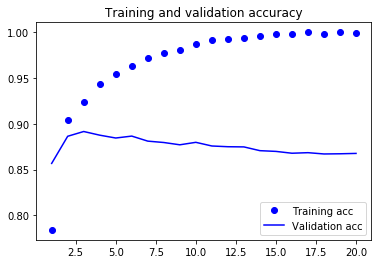

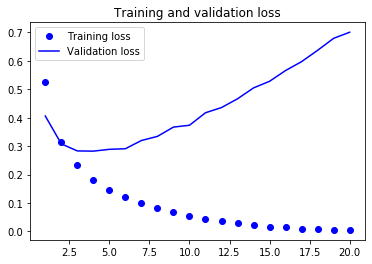

In [13]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The validation loss is minimized after ~3 epochs of training.

### 2.2.1. Test set performance

Based on the plots above, we should train our neural network on three epochs and test its performance on the test dataset.

In [14]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3, batch_size=512)

Epoch 1/3
25000/25000 [==============================] - 1s 31us/step - loss: 0.4614 - accuracy: 0.8283
Epoch 2/3
25000/25000 [==============================] - 1s 29us/step - loss: 0.2676 - accuracy: 0.9063
Epoch 3/3
25000/25000 [==============================] - 1s 29us/step - loss: 0.2054 - accuracy: 0.9274


We can then evaluate the model results.

In [15]:
results = model.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 1s 33us/step


[0.31023820934295654, 0.8751199841499329]

We can predict the probability that the review is positive for the test set.

In [16]:
model.predict(x_test)

array([[0.20337743],
       [0.99964243],
       [0.6937461 ],
       ...,
       [0.10345519],
       [0.08538473],
       [0.33991003]], dtype=float32)

## 2.3. Model Performance with Other Factors
### 2.3.1. Model Architecture
We shall both examine how the performance varies as we change the number of hidden layers and the number of units in each layer.
#### 2.3.1.1. Number of Layers
We shall try between 2 and 8 hidden layers. In all cases, we shall train on the optimum number of epochs (according to the validated loss) and use 16 hidden units.

In [17]:
nLayers = np.arange(2, 9, 1)

loss_values = np.zeros(len(nLayers))
val_loss_values = np.zeros(len(nLayers))
acc_values = np.zeros(len(nLayers))
val_acc_values = np.zeros(len(nLayers))
for i, n in enumerate(nLayers):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    for i in range(n - 1):
        model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    h = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                  validation_data=(x_val, y_val), verbose=0)
    h = h.history
    
    minInd = np.argmin(h['val_loss'])
    
    loss_values[i] = h['loss'][minInd]
    val_loss_values[i] = h['val_loss'][minInd]
    acc_values[i] = h['accuracy'][minInd]
    val_acc_values[i] = h['val_accuracy'][minInd]
    
    print("[# Layers: %s, Optimum Epochs: %s, Validation Loss: %s, Validation Accuracy: %s]"
          %(n, minInd + 1, val_loss_values[i], val_acc_values[i]))


[# Layers: 2, Optimum Epochs: 5, Validation Loss: 0.2790575984954834, Validation Accuracy: 0.886900007724762]
[# Layers: 3, Optimum Epochs: 3, Validation Loss: 0.27597945289611814, Validation Accuracy: 0.8912000060081482]
[# Layers: 4, Optimum Epochs: 3, Validation Loss: 0.285851846075058, Validation Accuracy: 0.8906000256538391]
[# Layers: 5, Optimum Epochs: 6, Validation Loss: 0.3277164887428284, Validation Accuracy: 0.8831999897956848]
[# Layers: 6, Optimum Epochs: 4, Validation Loss: 0.29443656730651857, Validation Accuracy: 0.8855000138282776]
[# Layers: 7, Optimum Epochs: 4, Validation Loss: 0.3084976258277893, Validation Accuracy: 0.8817999958992004]
[# Layers: 8, Optimum Epochs: 2, Validation Loss: 0.3304335892677307, Validation Accuracy: 0.8668000102043152]


Lets plot how the performance varies as we vary the architecture.

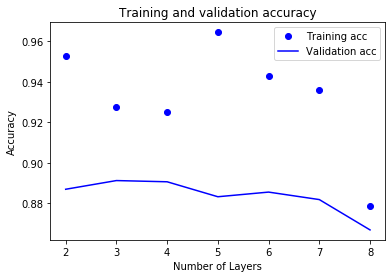

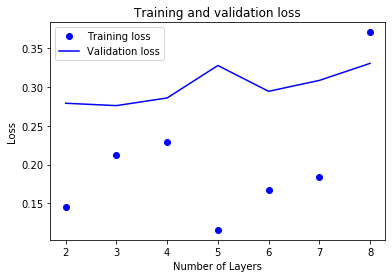

In [18]:
plt.plot(nLayers, acc_values, 'bo', label='Training acc')
plt.plot(nLayers, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(nLayers, loss_values, 'bo', label='Training loss')
plt.plot(nLayers, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of Layers')
plt.ylabel('Loss')
plt.legend()

The performance is relatively insensitive to the number of layers. Optimum seems to be two layers.

#### 2.3.1.2. Number of hidden units

Let us vary the number of hidden units whilst keeping the number of hidden layers at 2 and the number of epochs based on the optimum validation loss.

In [19]:
nUnits = [8, 16, 32, 64, 128]

loss_values = np.zeros(len(nUnits))
val_loss_values = np.zeros(len(nUnits))
acc_values = np.zeros(len(nUnits))
val_acc_values = np.zeros(len(nUnits))
for i, n in enumerate(nUnits):
    model = models.Sequential()
    model.add(layers.Dense(n, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(n, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    h = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                  validation_data=(x_val, y_val), verbose=0)
    h = h.history
    
    minInd = np.argmin(h['val_loss'])
    
    loss_values[i] = h['loss'][minInd]
    val_loss_values[i] = h['val_loss'][minInd]
    acc_values[i] = h['accuracy'][minInd]
    val_acc_values[i] = h['val_accuracy'][minInd]
    
    print("[# Units: %s, Optimum Epochs: %s, Validation Loss: %s, Validation Accuracy: %s]"
          %(n, minInd + 1, val_loss_values[i], val_acc_values[i]))


[# Units: 8, Optimum Epochs: 6, Validation Loss: 0.28034512991905214, Validation Accuracy: 0.8884000182151794]
[# Units: 16, Optimum Epochs: 4, Validation Loss: 0.2777158205509186, Validation Accuracy: 0.8888000249862671]
[# Units: 32, Optimum Epochs: 3, Validation Loss: 0.27424186553955077, Validation Accuracy: 0.8927000164985657]
[# Units: 64, Optimum Epochs: 2, Validation Loss: 0.2750406271457672, Validation Accuracy: 0.8903999924659729]
[# Units: 128, Optimum Epochs: 4, Validation Loss: 0.31101107654571536, Validation Accuracy: 0.8867999911308289]


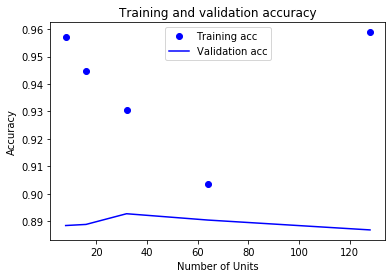

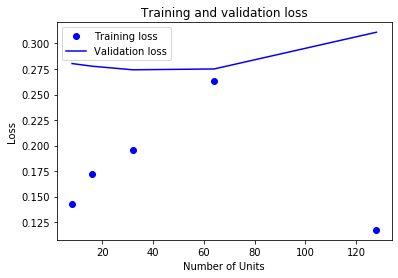

In [20]:
plt.plot(nUnits, acc_values, 'bo', label='Training acc')
plt.plot(nUnits, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of Units')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(nUnits, loss_values, 'bo', label='Training loss')
plt.plot(nUnits, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of Units')
plt.ylabel('Loss')
plt.legend()

The accuracy is relatively insensitive to the number of hidden units.

### 2.3.2. Using mse loss
We wish to study the impact of using a different loss function. Let's use an MSE loss when fitting the neural network.

In [21]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
history_mse = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                        validation_data=(x_val, y_val), verbose=0)

We can then compare it with the binary crossentropy loss.

In [23]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history_entropy = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                            validation_data=(x_val, y_val), verbose=0)

With both models fit, we can evaluate their accuracy.

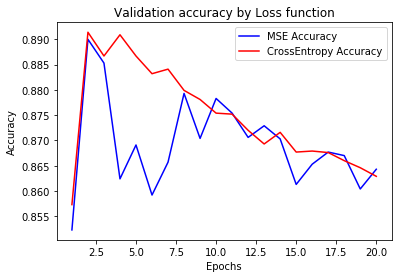

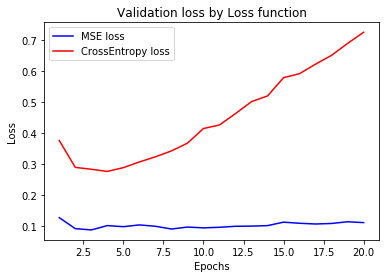

In [25]:
acc_values_mse = history_mse.history['val_accuracy']
acc_values_entropy = history_entropy.history['val_accuracy']
loss_values_mse = history_mse.history['val_loss']
loss_values_entropy = history_entropy.history['val_loss']

epochs = range(1, len(loss_values_mse) + 1)

plt.plot(epochs, acc_values_mse, 'b', label='MSE Accuracy')
plt.plot(epochs, acc_values_entropy, 'r', label='CrossEntropy Accuracy')
plt.title('Validation accuracy by Loss function')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values_mse, 'b', label='MSE loss')
plt.plot(epochs, loss_values_entropy, 'r', label='CrossEntropy loss')
plt.title('Validation loss by Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The Cross Entropy loss is marginally preferrable.
### 2.3.3. Effect of Activation Function
We shall compare a $\tanh$ vs a $\mathbf{relu}$ activation function. 

In [26]:
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
history_relu = history_entropy
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history_tanh = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                         validation_data=(x_val, y_val), verbose=0)

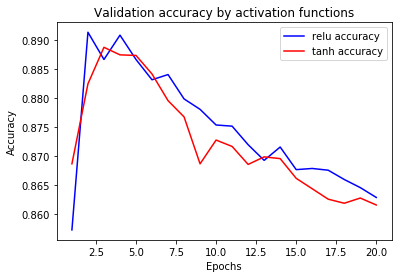

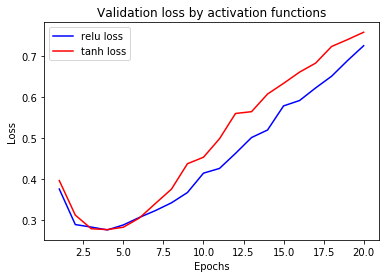

In [28]:
acc_values_relu = history_relu.history['val_accuracy']
acc_values_tanh = history_tanh.history['val_accuracy']
loss_values_relu = history_relu.history['val_loss']
loss_values_tanh = history_tanh.history['val_loss']

epochs = range(1, len(loss_values_relu) + 1)

plt.plot(epochs, acc_values_relu, 'b', label='relu accuracy')
plt.plot(epochs, acc_values_tanh, 'r', label='tanh accuracy')
plt.title('Validation accuracy by activation functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values_relu, 'b', label='relu loss')
plt.plot(epochs, loss_values_tanh, 'r', label='tanh loss')
plt.title('Validation loss by activation functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The relu activation tends to perform better.
### 2.3.4. Effect of Regularization

We can try both weight regularization and dropout.
#### 2.3.4.1. Dropout
We add 50% dropout to the output in each layer.

In [29]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
history_noreg = history_relu
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history_dropout = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                            validation_data=(x_val, y_val), verbose=0)

We can plot the validation loss and accuracy.

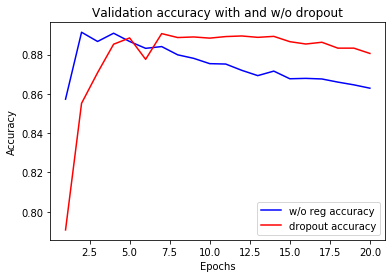

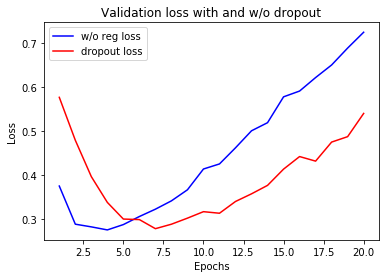

In [31]:
acc_values_noreg = history_noreg.history['val_accuracy']
acc_values_dropout = history_dropout.history['val_accuracy']
loss_values_noreg = history_noreg.history['val_loss']
loss_values_dropout = history_dropout.history['val_loss']

epochs = range(1, len(loss_values_noreg) + 1)

plt.plot(epochs, acc_values_noreg, 'b', label='w/o reg accuracy')
plt.plot(epochs, acc_values_dropout, 'r', label='dropout accuracy')
plt.title('Validation accuracy with and w/o dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values_noreg, 'b', label='w/o reg loss')
plt.plot(epochs, loss_values_dropout, 'r', label='dropout loss')
plt.title('Validation loss with and w/o dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

We can also examine how the model performs as we vary the dropout proportion.

In [32]:
dropoutC = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

loss_values = np.zeros(len(dropoutC))
val_loss_values = np.zeros(len(dropoutC))
acc_values = np.zeros(len(dropoutC))
val_acc_values = np.zeros(len(dropoutC))
for i, C in enumerate(dropoutC):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dropout(C))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(C))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    h = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                  validation_data=(x_val, y_val), verbose=0)
    h = h.history
    
    minInd = np.argmin(h['val_loss'])
    
    loss_values[i] = h['loss'][minInd]
    val_loss_values[i] = h['val_loss'][minInd]
    acc_values[i] = h['accuracy'][minInd]
    val_acc_values[i] = h['val_accuracy'][minInd]
    
    print("[Dropout proportion: %s, Optimum Epochs: %s, Validation Loss: %s, Validation Accuracy: %s]"
          %(C, minInd + 1, val_loss_values[i], val_acc_values[i]))

[Dropout proportion: 0, Optimum Epochs: 4, Validation Loss: 0.27530595550537107, Validation Accuracy: 0.8863000273704529]
[Dropout proportion: 0.05, Optimum Epochs: 4, Validation Loss: 0.27542461457252504, Validation Accuracy: 0.8885999917984009]
[Dropout proportion: 0.1, Optimum Epochs: 5, Validation Loss: 0.28753236303329466, Validation Accuracy: 0.8899999856948853]
[Dropout proportion: 0.15, Optimum Epochs: 4, Validation Loss: 0.2750455289363861, Validation Accuracy: 0.8910999894142151]
[Dropout proportion: 0.2, Optimum Epochs: 5, Validation Loss: 0.2730210955619812, Validation Accuracy: 0.8889999985694885]
[Dropout proportion: 0.25, Optimum Epochs: 5, Validation Loss: 0.27021672344207764, Validation Accuracy: 0.8919000029563904]
[Dropout proportion: 0.3, Optimum Epochs: 5, Validation Loss: 0.2717869435310364, Validation Accuracy: 0.8906000256538391]
[Dropout proportion: 0.35, Optimum Epochs: 5, Validation Loss: 0.2764514820098877, Validation Accuracy: 0.8881999850273132]
[Dropout p

We can plot how the performance of the model varies as we change the dropout coefficient.

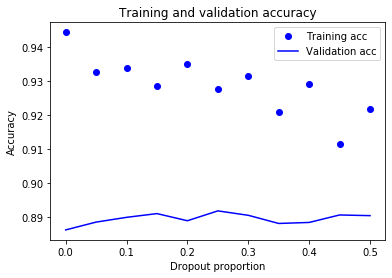

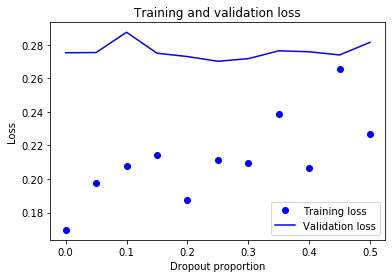

In [33]:
plt.plot(dropoutC, acc_values, 'bo', label='Training acc')
plt.plot(dropoutC, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Dropout proportion')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(dropoutC, loss_values, 'bo', label='Training loss')
plt.plot(dropoutC, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Dropout proportion')
plt.ylabel('Loss')
plt.legend()

The performane is relatively insensitive to the dropout coefficient.

#### 2.3.4.2. Weight Regularization
Instead of dropout, we can regularize the weights. We could either use a L1 penalty, an L2  penalty or some combination of the two.

In [34]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history_reg = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                        validation_data=(x_val, y_val), verbose=0)

We can plot the validation loss and accuracy.

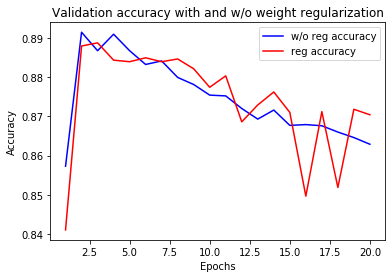

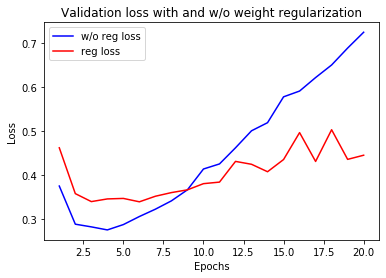

In [36]:
acc_values_noreg = history_noreg.history['val_accuracy']
acc_values_reg = history_reg.history['val_accuracy']
loss_values_noreg = history_noreg.history['val_loss']
loss_values_reg = history_reg.history['val_loss']

epochs = range(1, len(loss_values_noreg) + 1)

plt.plot(epochs, acc_values_noreg, 'b', label='w/o reg accuracy')
plt.plot(epochs, acc_values_reg, 'r', label='reg accuracy')
plt.title('Validation accuracy with and w/o weight regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values_noreg, 'b', label='w/o reg loss')
plt.plot(epochs, loss_values_reg, 'r', label='reg loss')
plt.title('Validation loss with and w/o weight regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

We can look at how L1 vs L2 regularization behave on this data. We find the number of epochs that minimizes the validated loss.

In [37]:
wghtReg = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

loss_values_L1 = np.zeros(len(wghtReg))
val_loss_values_L1 = np.zeros(len(wghtReg))
acc_values_L1 = np.zeros(len(wghtReg))
val_acc_values_L1 = np.zeros(len(wghtReg))
loss_values_L2 = np.zeros(len(wghtReg))
val_loss_values_L2 = np.zeros(len(wghtReg))
acc_values_L2 = np.zeros(len(wghtReg))
val_acc_values_L2 = np.zeros(len(wghtReg))
for i, w in enumerate(wghtReg):
    
    # train the L2 regularized model over all epochs
    model = models.Sequential()
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(w),
                           activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(w), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    h = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                  validation_data=(x_val, y_val), verbose=0)
    h = h.history
    
    minInd = np.argmin(h['val_loss'])
    
    loss_values_L2[i] = h['loss'][minInd]
    val_loss_values_L2[i] = h['val_loss'][minInd]
    acc_values_L2[i] = h['accuracy'][minInd]
    val_acc_values_L2[i] = h['val_accuracy'][minInd]
    
    print("[L2 weight: %s, Optimum Epochs: %s, Validation Loss: %s, Validation Accuracy: %s]"
          %(w, minInd + 1, val_loss_values_L2[i], val_acc_values_L2[i]))
    
    # train the L1 regularized model over all epochs
    model = models.Sequential()
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(w),
                           activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(w), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    h = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                  validation_data=(x_val, y_val), verbose=0)
    h = h.history
    
    minInd = np.argmin(h['val_loss'])
    
    loss_values_L1[i] = h['loss'][minInd]
    val_loss_values_L1[i] = h['val_loss'][minInd]
    acc_values_L1[i] = h['accuracy'][minInd]
    val_acc_values_L1[i] = h['val_accuracy'][minInd]
    
    print("[L1 weight: %s, Optimum Epochs: %s, Validation Loss: %s, Validation Accuracy: %s]"
          %(w, minInd + 1, val_loss_values_L1[i], val_acc_values_L1[i]))

[L2 weight: 1e-07, Optimum Epochs: 3, Validation Loss: 0.2770863851547241, Validation Accuracy: 0.8906999826431274]
[L1 weight: 1e-07, Optimum Epochs: 5, Validation Loss: 0.2889500257968903, Validation Accuracy: 0.8847000002861023]
[L2 weight: 1e-06, Optimum Epochs: 4, Validation Loss: 0.2737500909328461, Validation Accuracy: 0.8909000158309937]
[L1 weight: 1e-06, Optimum Epochs: 4, Validation Loss: 0.2763347977161407, Validation Accuracy: 0.8909000158309937]
[L2 weight: 1e-05, Optimum Epochs: 4, Validation Loss: 0.2792031986236572, Validation Accuracy: 0.8885999917984009]
[L1 weight: 1e-05, Optimum Epochs: 4, Validation Loss: 0.29869850001335146, Validation Accuracy: 0.888700008392334]
[L2 weight: 0.0001, Optimum Epochs: 3, Validation Loss: 0.2918654700756073, Validation Accuracy: 0.8895000219345093]
[L1 weight: 0.0001, Optimum Epochs: 5, Validation Loss: 0.36488949546813965, Validation Accuracy: 0.8866000175476074]
[L2 weight: 0.001, Optimum Epochs: 4, Validation Loss: 0.326327768754

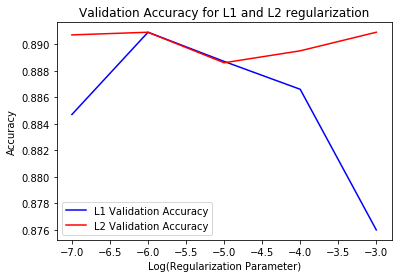

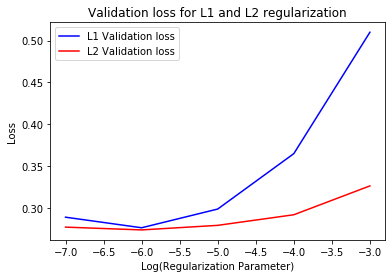

In [38]:
plt.plot(np.log10(wghtReg), val_acc_values_L1, 'b', label='L1 Validation Accuracy')
plt.plot(np.log10(wghtReg), val_acc_values_L2, 'r', label='L2 Validation Accuracy')
plt.title('Validation Accuracy for L1 and L2 regularization')
plt.xlabel('Log(Regularization Parameter)')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(np.log10(wghtReg), val_loss_values_L1, 'b', label='L1 Validation loss')
plt.plot(np.log10(wghtReg), val_loss_values_L2, 'r', label='L2 Validation loss')
plt.title('Validation loss for L1 and L2 regularization')
plt.xlabel('Log(Regularization Parameter)')
plt.ylabel('Loss')
plt.legend()

# 3. Recurrent Neural Network
The simple model cannot learn any interdependencies that exist between words. Indeed, for the simple model, we encoded all the information in a 10,000D vector with 1's corresponding to those words that occurred in reviews. We now move to consider one of the most popular network models: the RNN.

## 3.1. Simple Recurrent Neural Netowrk
In principle, this network can learn intricate interdependencies between words. However, in practice the network can only learn extremely short dependencies between words.  

We shall take as input into the network, reviews of at most 500 words and focus on only the 10,000 most common words.

In [39]:
from keras.layers import Embedding, SimpleRNN, Dense
from keras.preprocessing import sequence

In [40]:
max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x times)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x times)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let us now define the RNN. We embed each of the 10,000 most popular words occurring in the first 500 words of a review in a 32D space.

In [41]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


Let us fit the model to the data.

In [42]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 654us/step - loss: 0.5689 - acc: 0.6906 - val_loss: 0.3990 - val_acc: 0.8358
Epoch 2/10
20000/20000 [==============================] - 13s 645us/step - loss: 0.3483 - acc: 0.8586 - val_loss: 0.3768 - val_acc: 0.8378
Epoch 3/10
20000/20000 [==============================] - 13s 641us/step - loss: 0.2860 - acc: 0.8895 - val_loss: 1.0191 - val_acc: 0.6364
Epoch 4/10
20000/20000 [==============================] - 13s 641us/step - loss: 0.2470 - acc: 0.9049 - val_loss: 0.3560 - val_acc: 0.8744
Epoch 5/10
20000/20000 [==============================] - 13s 635us/step - loss: 0.2036 - acc: 0.9255 - val_loss: 0.3536 - val_acc: 0.8782
Epoch 6/10
20000/20000 [==============================] - 13s 638us/step - loss: 0.1559 - acc: 0.9441 - val_loss: 0.3590 - val_acc: 0.8608
Epoch 7/10
20000/20000 [==============================] - 13s 638us/step - loss: 0.1153 - acc: 0.9591 - val_loss: 0.3

We can then plot the model performance on both the training and validation sets.

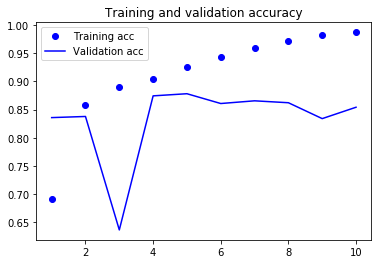

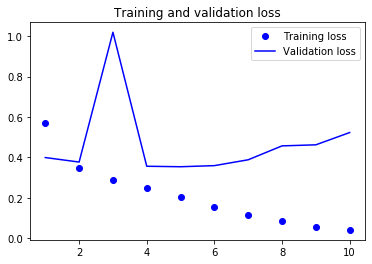

In [43]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The RNN's performance doesn't quite match up to the simple neural network. Partly this can be attributed to the RNN only considering the first 500 words of the review. Other issue is the inability of the model to learn long-term dependencies. We now turn our-attention to RNNs with this capability.

## 3.2. LSTM layers
LSTM models include a carry unit that has three distinct transformations that have the form.
```
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)


# *** carry through unit ***

# it has three distinct transformations: 
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

# we combine these transformations in the carry unit as follows:
c_t+1 = i_t * k_t + c_t * f_t  # 1st term updates carry with new info & 2nd helps carry forget irrelevant info
```
Let's use this to classify the IMDB reviews. We define the LSTM architecture.

In [44]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


We can then fit the model to the training data.

In [45]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.5318 - acc: 0.7550 - val_loss: 0.4533 - val_acc: 0.8004
Epoch 2/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.3205 - acc: 0.8737 - val_loss: 0.3791 - val_acc: 0.8362
Epoch 3/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.2463 - acc: 0.9047 - val_loss: 0.3168 - val_acc: 0.8636
Epoch 4/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.2066 - acc: 0.9222 - val_loss: 0.3239 - val_acc: 0.8882
Epoch 5/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1790 - acc: 0.9348 - val_loss: 0.3276 - val_acc: 0.8604
Epoch 6/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1600 - acc: 0.9430 - val_loss: 0.3476 - val_acc: 0.8816
Epoch 7/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1488 - acc: 0.9487 - val_loss: 0.2992 - val_acc:

We can then evaluate model performance on both the train and validation performance.

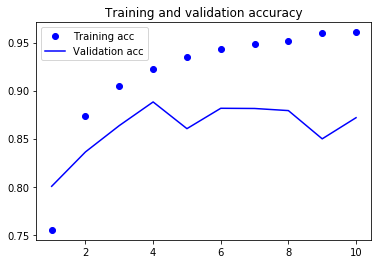

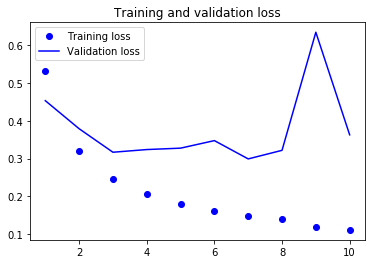

In [46]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The LSTM performs roughly the same as the simple neural network. This is because learning the long-term structure of reviews isn't helpful for sentiment analysis. LSTMs shine in question answering and machine translation.

## 3.3. Bidirectional LSTMs
This looks to learn sequence orders both forwards and backwards and combine the representations learnt.

In [47]:
model = Sequential()
model.add(layers.Embedding(10000, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


We can then fit the model and observe its performance.

In [48]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 35s 2ms/step - loss: 0.5177 - acc: 0.7577 - val_loss: 0.5303 - val_acc: 0.7840
Epoch 2/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.2945 - acc: 0.8863 - val_loss: 0.3088 - val_acc: 0.8718
Epoch 3/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.2315 - acc: 0.9129 - val_loss: 0.2826 - val_acc: 0.8856
Epoch 4/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.2038 - acc: 0.9245 - val_loss: 0.3052 - val_acc: 0.8726
Epoch 5/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.1765 - acc: 0.9368 - val_loss: 0.2981 - val_acc: 0.8884
Epoch 6/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.1595 - acc: 0.9430 - val_loss: 0.3683 - val_acc: 0.8604
Epoch 7/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.1409 - acc: 0.9506 - val_loss: 0.3500 - val_acc:

Let's plot the model performance.

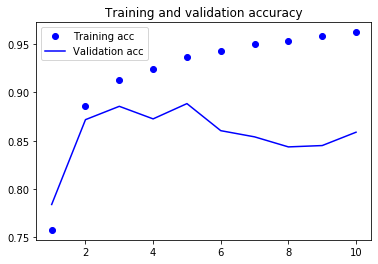

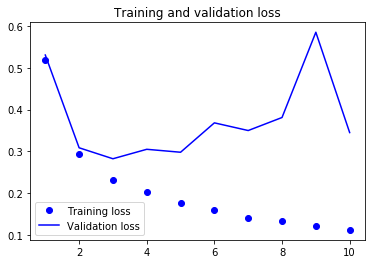

In [49]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model performs roughly as well as the simple model.

# 4. Using Covnets in NLP
We can use 1D covnets to learn local patterns in a sequence. We can afford larger patches with a 1D covnet as it corresponds to less feature vectors than would be the case in a high dimensional space. As with images, each patch has a transformation applied to it before being passed into a pooling layer.

Let us define a network with two convolutional layers.

In [50]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
___________________________________________

We can now fit the model.

In [51]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 19s 951us/step - loss: 7.1086 - acc: 0.4985 - val_loss: 1.1919 - val_acc: 0.5062
Epoch 2/10
20000/20000 [==============================] - 19s 953us/step - loss: 0.7682 - acc: 0.5167 - val_loss: 0.6860 - val_acc: 0.5762
Epoch 3/10
20000/20000 [==============================] - 19s 954us/step - loss: 0.6689 - acc: 0.6450 - val_loss: 0.6630 - val_acc: 0.6646
Epoch 4/10
20000/20000 [==============================] - 19s 957us/step - loss: 0.6235 - acc: 0.7461 - val_loss: 0.6088 - val_acc: 0.7174
Epoch 5/10
20000/20000 [==============================] - 19s 952us/step - loss: 0.5257 - acc: 0.8020 - val_loss: 0.4791 - val_acc: 0.8092
Epoch 6/10
20000/20000 [==============================] - 19s 960us/step - loss: 0.4003 - acc: 0.8478 - val_loss: 0.4077 - val_acc: 0.8344
Epoch 7/10
20000/20000 [==============================] - 19s 953us/step - loss: 0.3396 - acc: 0.8627 - val_loss: 0.3

We can subsequently plot the Convolutional network's performance.

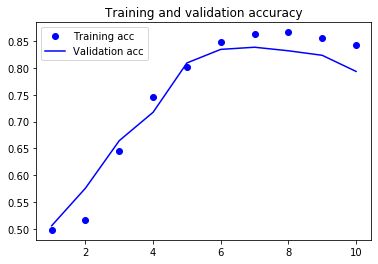

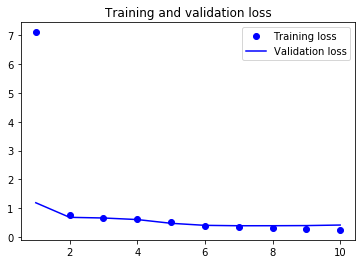

In [52]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model performance is pretty dissapointing. It does worse than the simple model.

# 5. Visualizing Model Behaviour
We can use TensorBoard to visualize how the model is behaving. It allows us to:
- monitor metrics during training
- visualize the model architecture
- provides histograms of activations and gradients
- explore embeddings in 3D

We re-run the convolutional neural network taking only the 2,000 most popular words in the first 500 words of each review.

In [53]:
from keras.preprocessing import sequence

maxlen = 500
max_features = 2000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen, name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
_______________________________________________

We can the compile the model.

In [54]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

We then create a directory to store the log files that TensorBoard generates (if it does not exist): `mkdir my_log_dir`. Once that is done, we can launch the training with a `TensorBoad` callback instance. The callback will write log events to the specified location.

In [55]:
import keras

log_dir = '/home/d869321/PycharmProjects/neuralExamples/my_log_dir'

# last two arguments specify after how many epochs activation histograms/embeddings should be recorded
callbacks = [keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, embeddings_freq=1)]
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks)

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/keras/callbacks/tensorboard_v2.py:102: UserWarning: The TensorBoard callback does not support embeddings display when using TensorFlow 2.0. Embeddings-related arguments are ignored.
  warnings.warn('The TensorBoard callback does not support '
/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 19s 931us/step - loss: 0.5777 - acc: 0.6968 - val_loss: 0.4264 - val_acc: 0.8344
Epoch 2/20
20000/20000 [==============================] - 18s 924us/step - loss: 0.4148 - acc: 0.8206 - val_loss: 0.4469 - val_acc: 0.8146
Epoch 3/20
20000/20000 [==============================] - 18s 924us/step - loss: 0.3828 - acc: 0.7781 - val_loss: 0.6171 - val_acc: 0.7240
Epoch 4/20
20000/20000 [==============================] - 18s 923us/step - loss: 0.3224 - acc: 0.7655 - val_loss: 0.5140 - val_acc: 0.7452
Epoch 5/20
20000/20000 [==============================] - 18s 923us/step - loss: 0.2941 - acc: 0.7193 - val_loss: 0.5183 - val_acc: 0.7258
Epoch 6/20
20000/20000 [==============================] - 18s 923us/step - loss: 0.2511 - acc: 0.6764 - val_loss: 1.3825 - val_acc: 0.4502
Epoch 7/20
20000/20000 [==============================] - 18s 924us/step - loss: 0.2048 - acc: 0.6206 - val_loss: 0.7

We can then run `tensorboard --logdir=my_log_dir` and go to `http://localhost:6006` to access a dashboard exploring the model behaviour.

We can also plot the model architecture.

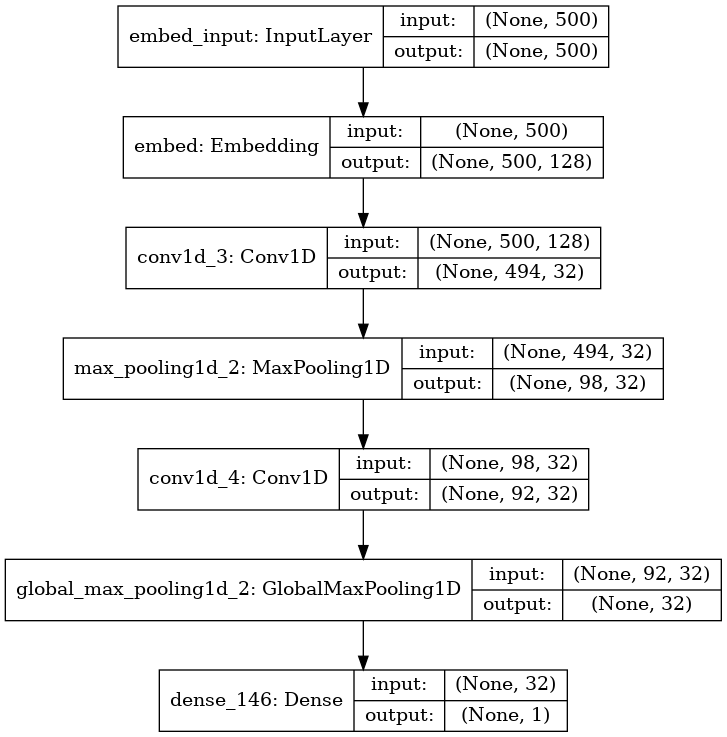

In [56]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')
plot_model(model, show_shapes=True, to_file='modelDetailed.png')  # gives shape info at each layer